In [3524]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.model_selection import train_test_split
import sklearn.model_selection
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import scale

In [ ]:
BIST50 = ["TUPRS", "VAKBN","TOASO","KRDMD","MGROS","DOHOL","AKBNK","TKFEN","FROTO","GARAN","KOZAA","HALKB",
         "KORDS","TCELL","ENKAI","KOZAL","VESTL","TSKB","YKBNK","SODA","TTKOM","SKBNK","BIMAS","ODAS","PETKM",
          "SISE","ANACM", "ARCLK", "YATAS", "EREGL", "SASA", "ALARK", "SAHOL", "AEFES", "EKGYO", "THYAO",
         "HEKTS", "PGSUS", "ISCTR", "TRKCM", "KCHOL", "ISFIN", "ASELS", "TAVHL","IPEKE","ULKER","CCOLA",
         "GUBRF","AGHOL", "ENJSA"]

In [ ]:
BIST100 = ["GUSGR", "ALGYO", "KAREL", "ALKIM", "TTRAK", "LOGO", "AKCNS", "GOZDE", "BRSAN", 
           "ECZYT", "DOAS", "NETAS", "TMSN", "ZOREN", "CLEBI", "KERVT", "TRGYO", "AYGAZ", "GOODY",
          "ISMEN", "BRISA", "CEMTS", "AKSEN", "KARTN", "GLYHO", "ISGYO", "DEVA", "ECILC", "KARSN",
          "SARKY", "ALBRK", "ANHYT", "RYGYO", "BUCIM", "EGEEN", "CIMSA", "NTHOL", "HLGYO","MPARK",
          "SELEC", "OZKGY", "OTKAR", "AKSA", "AKGRT", "KLMSN", "BIZIM", "TATGD", "ISDMR", "MAVI",
          "SOKM"]

In [4347]:
frame_ = pd.read_pickle("frame_whole_BIST100")

In [4385]:
stock_name = "TTRAK"
start_date = "01-01-2015"
end_date = "31-01-2020"

In [4386]:
frame = frame_.loc[frame_["stock_name"] == stock_name]
frame = frame.loc[frame.index > start_date]
frame = frame.loc[frame.index < end_date]

In [4387]:
# MA_100_CH 0'dan büyük ve MA_14_CH de -0.05'ten büyükse
frame['check_1'] = frame['MA_200_CH'] > -0
frame['check_2'] = frame['MA_100_CH'] > -0.001
frame['check_3'] = frame['MA_50_CH'] > -0.002
frame['check_4'] = frame['MA_14_CH'] > -0.003
frame['check_5'] = frame['MA_14'] > (frame['MA_100']*0.90)
frame['check_6'] = frame['MA_20'] > (frame['MA_200']*0.95)
frame['check_7'] = frame['RSI_5'] > 35
frame['check_8'] = frame["StockValue_momentum"] > 100

frame['check_9'] = frame["MA_14_CH_CH"] > -2
frame['check_10'] = frame["MA_50_CH_CH"] > -1
frame['check_11'] = frame["MA_200_CH_CH"] > -0.5
frame['check_12'] = frame["MA_100_CH_CH"] > -0.1

frame['check_13'] = frame['market_positive_ma_10'] > 0.35
frame['check_14'] = frame['RSI_5_CH'] > -0.02
frame['check_15'] = frame['RSI_CH'] > -0.02

In [4388]:
frame["first_check"] = frame.iloc[:,-15:-7].sum(axis=1)
frame["second_check"] = frame.iloc[:,-8:-4].sum(axis=1)
frame["third_check"] = frame.iloc[:,-5:-2].sum(axis=1)

In [4389]:
# MA_100_CH 0'dan büyük ve MA_14_CH de -0.05'ten büyükse
frame['day'] = np.where((frame["first_check"] == 8) &
                        (frame["second_check"] >=3) &
                        (frame["third_check"] >=2)
                        , "BUY", "SELL")

In [4390]:
locations = []
start = 0
for row in range(frame.shape[0]-1):
    if frame.day[row] == "BUY":
        mode = "BUY"
        if (frame.day[row] == "BUY" and frame.day[row+1] == "SELL"):
            end = row+1
            loc = [start, end]
            locations.append(loc)

    else:
        mode = "SELL"
        if (frame.day[row] == "SELL" and frame.day[row+1] == "BUY"):
            start = row+1

In [4391]:
locations

[[0, 18],
 [31, 33],
 [41, 43],
 [46, 47],
 [51, 60],
 [61, 66],
 [69, 72],
 [73, 83],
 [147, 159],
 [191, 199],
 [200, 202],
 [203, 205],
 [295, 340],
 [342, 343],
 [354, 368],
 [369, 370],
 [372, 373],
 [374, 376],
 [380, 392],
 [404, 419],
 [422, 424],
 [440, 445],
 [447, 450],
 [451, 453],
 [557, 560],
 [562, 585],
 [600, 601],
 [602, 607],
 [637, 659],
 [660, 661],
 [665, 667],
 [673, 685],
 [711, 712],
 [723, 727],
 [1173, 1175],
 [1178, 1201],
 [1211, 1277]]

In [4392]:
sum([i[1] - i[0] for i in locations])

342

In [4393]:
rets = []
for obs in locations:
    ret = (frame.StockValue[obs[1]] - frame.StockValue[obs[0]]) / frame.StockValue[obs[0]]
    rets.append(ret)
rets

[0.05331502509668387,
 -0.04425798841947243,
 -0.008739043280482126,
 -0.03098475589733903,
 0.0009680228174490478,
 0.019181027891921776,
 -0.012345832485156354,
 0.003768101275430373,
 -0.03892582299225373,
 -0.04903893954711212,
 -0.00538003023516057,
 -0.010067664028248258,
 0.0972833117723157,
 0.0018412148650032018,
 -0.003047191036295993,
 -0.031773829686567744,
 -0.010404271463009703,
 -0.02007254836209618,
 -0.08928544682890566,
 0.02870847436293835,
 -0.023228195836300015,
 -0.011934219846782229,
 -0.008357858367076716,
 -0.024744021414263573,
 0.003049048392833411,
 0.044088059806893155,
 -0.01992596242801355,
 0.00824413243120553,
 0.021942632791459877,
 -0.02781003177195634,
 -0.011343359673718956,
 -0.03900779722623696,
 -0.009198034012323459,
 -0.01819425042070269,
 0.03723404255319145,
 -0.008200922603792933,
 0.3571626704278326]

In [4394]:
indexes

[13, 15, 17, 19, 32, 34, 40, 41, 44, 47, 52, 55, 57, 61, 67, 68, 69, 72]

In [4395]:
try:
    [rets[i] for i in indexes]
except:
    print("not yet!")

not yet!


In [4396]:
try:
    [rets[i] for i in indexes if rets[i] !=0]
except:
    print("not yet!")

not yet!


In [4397]:
try:
    effect = np.prod([1+rets[i] for i in indexes if rets[i] !=0])
    effect
except:
    print("not yet!")

not yet!


In [4398]:
rets = [ret + 1 for ret in rets]

In [4399]:
retur = 1
for ret in rets:
    retur = retur * ret
retur

1.0505806438069911

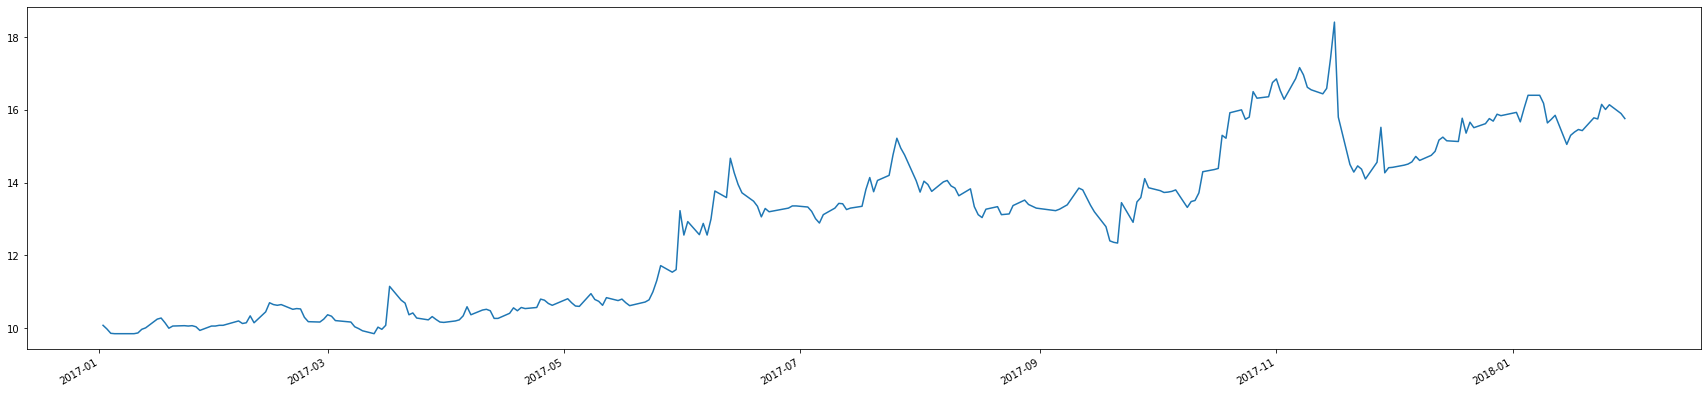

In [4382]:
frame["StockValue"].plot(figsize=[30,7])

In [4383]:
try:
    retur / effect
except:
    print("not yet!")

In [4384]:
frame.iloc[56:68,-26:]

,StockValue,StockValue_momentum,market_positive,market_positive_ma_10,stock_name,volume,volume_ma_14,check_1,check_2,check_3,...,check_10,check_11,check_12,check_13,check_14,check_15,first_check,second_check,third_check,day
2017-03-21,10.69,103.085824,0.429003,0.465438,NETAS,34602554.0,2.704267e+07,True,True,True,...,True,True,True,True,True,True,8,4,3,BUY
2017-03-22,10.37,100.387222,0.305389,0.464300,NETAS,13547231.0,2.711647e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY
2017-03-23,10.42,102.056807,0.559375,0.470867,NETAS,17313190.0,2.788906e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY
2017-03-24,10.28,100.982318,0.541935,0.471214,NETAS,7572969.0,2.806961e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY
2017-03-27,10.23,100.589971,0.365325,0.469740,NETAS,4620179.0,2.824212e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY
2017-03-28,10.32,102.788845,0.478528,0.480170,NETAS,14931234.0,2.903666e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY
2017-03-29,10.24,102.502503,0.227139,0.455599,NETAS,14795585.0,2.988852e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY
2017-03-30,10.17,102.416918,0.557994,0.456047,NETAS,6542459.0,3.009719e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY
2017-03-31,10.16,103.147208,0.472669,0.452855,NETAS,6277531.0,3.033385e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY
2017-04-03,10.20,101.694915,0.541284,0.447864,NETAS,8585509.0,3.056058e+07,True,True,True,...,True,False,True,True,True,True,8,3,3,BUY


---

In [3560]:
start_index = [i[0] for i in locations]
start_index

[28, 51, 63, 109, 112, 139, 165, 190, 210, 228, 244, 248]

In [3561]:
durations = [i[1]-i[0] for i in locations]
durations

[21, 0, 38, 0, 8, 8, 23, 0, 3, 12, 0, 1]

In [3562]:
rets = [ret for ret in rets]
rets

[1.1445221957355187,
 1.0,
 1.1235849056603775,
 1.0,
 1.0016515276630884,
 0.9746938775510203,
 1.0630782169890665,
 1.0,
 1.005982905982906,
 0.9888712241653418,
 1.0,
 0.9954128440366972]

In [3563]:
df = pd.DataFrame(list(zip(start_index, durations, rets)), 
               columns =['index', 'duration', 'returns']) 

In [3564]:
df

,index,duration,returns
0,28,21,1.144522
1,51,0,1.000000
2,63,38,1.123585
3,109,0,1.000000
4,112,8,1.001652
5,139,8,0.974694
6,165,23,1.063078
7,190,0,1.000000
8,210,3,1.005983
9,228,12,0.988871


In [3565]:
data = frame.iloc[start_index,:]

In [3566]:
data

,MA_7,MA_14,MA_20,MA_50,MA_100,MA_200,MA_7_CH,MA_7_CH_CH,MA_14_CH,MA_14_CH_CH,...,check_10,check_11,check_12,check_13,check_14,check_15,first_check,second_check,third_check,day
2019-02-11,8.828057,8.758950,8.723845,9.054886,9.466794,8.304146,0.001627,-0.382034,0.000234,-0.351937,...,True,True,True,True,True,True,8,4,2,BUY
2019-03-14,10.393829,10.467771,10.235385,9.359416,9.534512,8.697822,0.005631,-0.011933,0.008841,0.053821,...,True,True,True,True,True,True,8,4,2,BUY
2019-04-01,10.504286,10.529900,10.489765,9.797820,9.561496,8.944501,0.000422,0.478022,0.000755,-0.165259,...,True,True,True,True,True,True,8,4,2,BUY
2019-06-11,12.218571,12.159286,12.242500,11.758600,10.705858,10.086470,-0.001006,-12.367166,0.000166,-0.177018,...,True,True,True,True,True,True,8,4,2,BUY
2019-06-14,12.337143,12.157143,12.209000,11.867000,10.814151,10.147630,-0.000111,-12.427226,-0.000221,-0.038477,...,True,True,True,True,True,True,8,4,2,BUY
2019-07-24,11.912857,11.916429,11.975000,12.139400,11.606492,10.547815,-0.001244,0.017954,-0.001674,0.034700,...,True,True,True,True,True,True,8,4,2,BUY
2019-09-04,11.698571,11.578571,11.605500,11.901800,11.921800,10.755476,-0.000460,0.055745,-0.002612,0.032779,...,True,True,True,True,True,True,8,4,2,BUY
2019-10-09,12.568571,12.648571,12.506000,12.065000,12.100200,11.105780,0.002463,-0.014586,0.003790,0.011464,...,True,True,True,True,True,True,8,4,2,BUY
2019-11-07,11.638571,11.594286,11.491500,11.961000,11.950900,11.347284,0.001768,-0.110101,-0.002518,0.033450,...,True,True,True,True,True,True,8,4,2,BUY
2019-12-03,11.807143,11.650714,11.671500,11.843800,11.866700,11.611505,0.000676,0.422807,-0.000403,-0.160870,...,True,True,True,True,True,True,8,4,2,BUY


In [3567]:
df.index = data.index

In [3568]:
data = data.join(df)

In [3569]:
data["target"] = np.where(data['duration'] < 1, 0, 1)

In [3570]:
data = data.drop(['stock_name'], axis=1)

In [3571]:
data_for_test_xgboost = data.iloc[:,:30]

In [3572]:
data_for_test_xgboost['marketV_to_bookV'] = data_for_test_xgboost['marketV_to_bookV'].astype(float)

In [3573]:
data_for_test_xgboost.shape

(12, 30)

---

In [3574]:
BIST50 = ["TUPRS", "VAKBN","TOASO","KRDMD","MGROS","DOHOL","AKBNK","TKFEN","FROTO","GARAN","KOZAA","HALKB",
         "KORDS","TCELL","ENKAI","KOZAL","VESTL","TSKB","YKBNK","SODA","TTKOM","SKBNK","BIMAS","ODAS","PETKM",
          "SISE","ANACM", "ARCLK", "YATAS", "EREGL", "SASA", "ALARK", "SAHOL", "AEFES", "EKGYO", "THYAO",
         "HEKTS", "PGSUS", "ISCTR", "TRKCM", "KCHOL", "ISFIN", "ASELS", "TAVHL","IPEKE","ULKER","CCOLA",
         "GUBRF","AGHOL", "ENJSA"]

In [4400]:
frame_ = pd.read_pickle("frame_whole_BIST50")

In [4401]:
stocks = BIST50
# np.random.shuffle(stocks)
# stocks = np.array_split(stocks, 3)
# stocks = list(stocks[0])
# stocks

In [4402]:
start_date = "01-01-2014"
end_date = "31-01-2019"
datas = [] 
duration = []
transaction = []
short_transaction = [] 
negatives = []
positives = [] 
returns = [] 

for stock in stocks:
    frame = frame_.loc[frame_["stock_name"] == stock]
    frame = frame.loc[frame.index > start_date]
    frame = frame.loc[frame.index < end_date]
    
    frame['day'] = np.where((frame['MA_200_CH'] > 0) &
                        (frame['MA_100_CH'] > -0.001) &
                        (frame['MA_50_CH'] > -0.002) &
                        (frame['MA_14_CH'] > -0.003) &
                        # (frame['MA_7'] > frame['MA_50']) &
                        (frame['MA_14'] > (frame['MA_100']*0.90)) &
                        (frame['MA_20'] > (frame['MA_200']*0.95)) &
                        (frame['RSI_5'] > 35) &
                        (frame['RSI_5_CH'] > -0.02) &
                        (frame['RSI_CH'] > -0.02) &
                        (frame["StockValue_momentum"] > 100) &
                        (frame["MA_14_CH_CH"] > -3) &
                        (frame["MA_50_CH_CH"] > -2) &
                        (frame["MA_200_CH_CH"] > -1) &
                        (frame["MA_100_CH_CH"] > -0.5) &
                        (frame['market_positive_ma_10'] > 0.35)
                        # (frame['marketV_to_bookV'] < 10)
                        , "BUY", "SELL")
    
    locations = []
    start = 0
    for row in range(frame.shape[0]-1):
        if frame.day[row] == "BUY":
            mode = "BUY"
            if (frame.day[row] == "BUY" and frame.day[row+1] == "SELL"):
                end = row
                loc = [start, end]
                locations.append(loc)

        else:
            mode = "SELL"
            if (frame.day[row] == "SELL" and frame.day[row+1] == "BUY"):
                start = row+1
        
    duration.append(sum([i[1] - i[0] for i in locations])) 
    transaction.append(len(locations))
    short_transaction.append(len([i for i in locations if i[0]-i[1] == 0]))
        
    rets = []
    for obs in locations:
        ret = (frame.StockValue[obs[1]] - frame.StockValue[obs[0]]) / frame.StockValue[obs[0]]
        rets.append(ret)
        
    rets = [ret + 1 for ret in rets]
    
    retur = 1
    for ret in rets:
        retur = retur * ret
        
    rets = np.array(rets)
    
    negative_ones = rets[np.where(rets<1)]
    negatives.append(negative_ones)
    
    positive_ones = rets[np.where(rets>1)]
    positives.append(positive_ones)
    
    returns.append(retur)
    
    start_index = [i[0] for i in locations]
    durations = [i[1]-i[0] for i in locations]
    rets = [ret for ret in rets]

    df = pd.DataFrame(list(zip(start_index, durations, rets)), 
                   columns =['index', 'duration', 'returns']) 

    
    data = frame.iloc[start_index,:]

    df.index = data.index

    data = data.join(df)

    data["target"] = np.where(data['duration'] < 2, 0, 1) # 3 günden kısa olanlar

    data = data.drop(['stock_name'], axis=1)
    
    datas.append(data)

In [4403]:
data = pd.concat(datas)

In [4404]:
data

,MA_7,MA_14,MA_20,MA_50,MA_100,MA_200,MA_7_CH,MA_7_CH_CH,MA_14_CH,MA_14_CH_CH,...,StockValue_momentum,market_positive,market_positive_ma_10,volume,volume_ma_14,day,index,duration,returns,target
2014-05-05,32.124843,31.945814,31.739435,29.194278,28.021981,28.174880,0.002214,-0.071603,0.004245,-0.025212,...,101.291520,0.445578,0.517440,26278357.0,2.572059e+07,BUY,85,0,1.000000,0
2014-05-12,32.052243,32.023221,31.951130,29.844400,28.145335,28.239498,0.000489,-0.177785,0.001888,-0.085006,...,102.148123,0.556314,0.575591,14544525.0,2.407375e+07,BUY,90,20,1.107255,1
2014-06-12,35.032943,34.740207,34.379715,32.756158,29.616836,28.939821,0.003352,0.012261,0.004200,0.062480,...,100.702102,0.771331,0.505968,41711276.0,3.384239e+07,BUY,112,0,1.000000,0
2014-07-08,33.920043,34.094243,34.132465,33.757160,31.151858,29.608243,-0.001057,9.060322,-0.001318,0.985147,...,100.196725,0.476868,0.492032,34896214.0,3.059866e+07,BUY,130,0,1.000000,0
2014-07-15,34.297457,34.002300,34.156175,33.972582,31.583430,29.747523,-0.000356,0.007237,-0.001203,1.067930,...,100.496847,0.548611,0.553326,31897804.0,2.735996e+07,BUY,135,15,1.013848,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-25,21.877014,22.048743,21.966465,21.834330,20.935078,17.018243,0.000544,-0.125206,0.001471,-0.152927,...,101.328869,0.625767,0.576823,2016335.0,1.556926e+06,BUY,897,14,1.013110,1
2017-10-31,21.118029,20.906129,20.190855,20.558772,21.373718,19.893714,0.009225,0.052368,0.007766,-0.251236,...,115.038861,0.458689,0.496883,4000992.0,2.578508e+06,BUY,964,9,1.065587,1
2017-12-15,21.391686,20.948029,20.818850,21.093834,21.239786,21.087432,0.002513,-0.107409,-0.002546,-0.299119,...,106.357845,0.579439,0.605509,1376894.0,1.524265e+06,BUY,997,27,1.331207,1
2018-01-29,28.529757,27.481286,26.572280,23.507812,22.077692,22.026512,0.011561,0.028955,0.011168,0.032603,...,116.523056,0.500000,0.582738,9218751.0,8.314452e+06,BUY,1027,5,0.946234,1


In [4405]:
# data = data.drop(["stock_name"], axis=1)

In [4406]:
data = data.dropna()

In [4407]:
data.target.value_counts()

1    1094
0     644
Name: target, dtype: int64

In [4408]:
# Features and Target
y = data[["target"]]
targets = y

features = data.drop("target", axis=1)
X = features

In [3631]:
X = X.iloc[:,:-4]

In [3632]:
X['marketV_to_bookV'] = X['marketV_to_bookV'].astype(float)

In [3633]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2020, stratify=y)

In [3634]:
# Translate these sets into XGBoost-compatible dense matrices
d_train = xgb.DMatrix(X_train.values, label=y_train.values, feature_names=X_train.columns)
d_validation = xgb.DMatrix(X_test, label=y_test.values, feature_names=X_test.columns)

In [3635]:
# Parametrize a watch list to follow the training performance
watch_list = [(d_train, 'train'), (d_validation, 'validation')]

In [3636]:
# Parameters
params = {"eta": 0.01, 
          "tree_method" : "hist",
          "grow_policy" : 'depthwise',
          "max_depth" : 6, 
          "subsample" : 0.9, 
          "colsample_bytree" : 0.9,
          "min_child_weight" : 1,
          "objective" : 'binary:hinge', 
           # "base_score" : perc_def,
          "scale_pos_weight" : 1,
           # "n_estimators" : 1000, 
          "eval_metric" : "auc",
          "seed" : 13,
          "gamma" : 0.11,
          "nthread" : 14,
          "reg_alpha" : 0,
          "verbosity" : 1}

MODEL_NUMBER_OF_ROUNDS = 2000
MODEL_EARLY_STOPPING_ROUNDS = 500

In [3637]:
model = xgb.train(params=params,
                        dtrain=d_train,
                        num_boost_round=MODEL_NUMBER_OF_ROUNDS,
                        evals=watch_list,
                        early_stopping_rounds=MODEL_EARLY_STOPPING_ROUNDS
)

[22:46:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	validation-auc:0.50000
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 500 rounds.
[1]	train-auc:0.50000	validation-auc:0.50000
[2]	train-auc:0.50000	validation-auc:0.50000
[3]	train-auc:0.50000	validation-auc:0.50000
[4]	train-auc:0.50000	validation-auc:0.50000
[5]	train-auc:0.50000	validation-auc:0.50000
[6]	train-auc:0.50000	validation-auc:0.50000
[7]	train-auc:0.50000	validation-auc:0.50000
[8]	train-auc:0.50000	validation-auc:0.50000
[9]	train-auc:0.50000	validation-auc:0.50000
[10]	train-auc:0.50000	validat

[166]	train-auc:0.79126	validation-auc:0.55421
[167]	train-auc:0.79223	validation-auc:0.55421
[168]	train-auc:0.79320	validation-auc:0.55193
[169]	train-auc:0.79417	validation-auc:0.55193
[170]	train-auc:0.79709	validation-auc:0.55580
[171]	train-auc:0.80000	validation-auc:0.55968
[172]	train-auc:0.80194	validation-auc:0.55968
[173]	train-auc:0.80291	validation-auc:0.55968
[174]	train-auc:0.80388	validation-auc:0.55511
[175]	train-auc:0.80583	validation-auc:0.56127
[176]	train-auc:0.80680	validation-auc:0.55899
[177]	train-auc:0.80874	validation-auc:0.55899
[178]	train-auc:0.80971	validation-auc:0.56286
[179]	train-auc:0.80874	validation-auc:0.56286
[180]	train-auc:0.80874	validation-auc:0.56286
[181]	train-auc:0.81068	validation-auc:0.56674
[182]	train-auc:0.81262	validation-auc:0.57062
[183]	train-auc:0.81456	validation-auc:0.57062
[184]	train-auc:0.81651	validation-auc:0.57062
[185]	train-auc:0.81651	validation-auc:0.57062
[186]	train-auc:0.81845	validation-auc:0.57062
[187]	train-a

[341]	train-auc:0.94158	validation-auc:0.60476
[342]	train-auc:0.94158	validation-auc:0.61251
[343]	train-auc:0.94158	validation-auc:0.61023
[344]	train-auc:0.94158	validation-auc:0.61023
[345]	train-auc:0.94255	validation-auc:0.61410
[346]	train-auc:0.94255	validation-auc:0.61798
[347]	train-auc:0.94255	validation-auc:0.61023
[348]	train-auc:0.94352	validation-auc:0.61410
[349]	train-auc:0.94546	validation-auc:0.61410
[350]	train-auc:0.94546	validation-auc:0.61410
[351]	train-auc:0.94546	validation-auc:0.61798
[352]	train-auc:0.94489	validation-auc:0.61798
[353]	train-auc:0.94489	validation-auc:0.61798
[354]	train-auc:0.94489	validation-auc:0.61798
[355]	train-auc:0.94489	validation-auc:0.61798
[356]	train-auc:0.94546	validation-auc:0.61569
[357]	train-auc:0.94586	validation-auc:0.61569
[358]	train-auc:0.94740	validation-auc:0.61957
[359]	train-auc:0.94740	validation-auc:0.62345
[360]	train-auc:0.94740	validation-auc:0.62345
[361]	train-auc:0.94837	validation-auc:0.61957
[362]	train-a

[516]	train-auc:0.98875	validation-auc:0.61405
[517]	train-auc:0.98875	validation-auc:0.61405
[518]	train-auc:0.98972	validation-auc:0.61405
[519]	train-auc:0.98972	validation-auc:0.61405
[520]	train-auc:0.98972	validation-auc:0.61792
[521]	train-auc:0.99069	validation-auc:0.61792
[522]	train-auc:0.99069	validation-auc:0.62180
[523]	train-auc:0.99069	validation-auc:0.61792
[524]	train-auc:0.99069	validation-auc:0.61405
[525]	train-auc:0.99069	validation-auc:0.61792
[526]	train-auc:0.99263	validation-auc:0.61633
[527]	train-auc:0.99166	validation-auc:0.61246
[528]	train-auc:0.99263	validation-auc:0.61405
[529]	train-auc:0.99263	validation-auc:0.61405
[530]	train-auc:0.99555	validation-auc:0.61952
[531]	train-auc:0.99555	validation-auc:0.61952
[532]	train-auc:0.99555	validation-auc:0.61952
[533]	train-auc:0.99555	validation-auc:0.61564
[534]	train-auc:0.99555	validation-auc:0.61177
[535]	train-auc:0.99555	validation-auc:0.61564
[536]	train-auc:0.99555	validation-auc:0.61792
[537]	train-a

[691]	train-auc:1.00000	validation-auc:0.59122
[692]	train-auc:1.00000	validation-auc:0.58893
[693]	train-auc:1.00000	validation-auc:0.59122
[694]	train-auc:1.00000	validation-auc:0.58893
[695]	train-auc:1.00000	validation-auc:0.58278
[696]	train-auc:1.00000	validation-auc:0.57890
[697]	train-auc:1.00000	validation-auc:0.58734
[698]	train-auc:1.00000	validation-auc:0.57890
[699]	train-auc:1.00000	validation-auc:0.58278
[700]	train-auc:1.00000	validation-auc:0.58118
[701]	train-auc:1.00000	validation-auc:0.58734
[702]	train-auc:1.00000	validation-auc:0.58347
[703]	train-auc:1.00000	validation-auc:0.58416
[704]	train-auc:1.00000	validation-auc:0.57731
[705]	train-auc:1.00000	validation-auc:0.58187
[706]	train-auc:1.00000	validation-auc:0.57959
[707]	train-auc:1.00000	validation-auc:0.57731
[708]	train-auc:1.00000	validation-auc:0.57731
[709]	train-auc:1.00000	validation-auc:0.58187
[710]	train-auc:1.00000	validation-auc:0.57959
[711]	train-auc:1.00000	validation-auc:0.58187
[712]	train-a

[866]	train-auc:1.00000	validation-auc:0.56956
[867]	train-auc:1.00000	validation-auc:0.57025
[868]	train-auc:1.00000	validation-auc:0.56956
[869]	train-auc:1.00000	validation-auc:0.57025
[870]	train-auc:1.00000	validation-auc:0.56956
[871]	train-auc:1.00000	validation-auc:0.57025
[872]	train-auc:1.00000	validation-auc:0.56956
[873]	train-auc:1.00000	validation-auc:0.57025
[874]	train-auc:1.00000	validation-auc:0.56956
[875]	train-auc:1.00000	validation-auc:0.57025
[876]	train-auc:1.00000	validation-auc:0.56956
[877]	train-auc:1.00000	validation-auc:0.57025
[878]	train-auc:1.00000	validation-auc:0.56956
[879]	train-auc:1.00000	validation-auc:0.57025
[880]	train-auc:1.00000	validation-auc:0.56956
[881]	train-auc:1.00000	validation-auc:0.57025
[882]	train-auc:1.00000	validation-auc:0.56956
[883]	train-auc:1.00000	validation-auc:0.57025
[884]	train-auc:1.00000	validation-auc:0.56956
[885]	train-auc:1.00000	validation-auc:0.57025
[886]	train-auc:1.00000	validation-auc:0.56956
[887]	train-a

In [3638]:
best_iteration = model.best_ntree_limit
print("Best iteration: " + str(best_iteration))

Best iteration: 479


In [3639]:
ypred = model.predict(d_validation, ntree_limit=best_iteration)

In [3640]:
ypred

array([1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 1., 1.

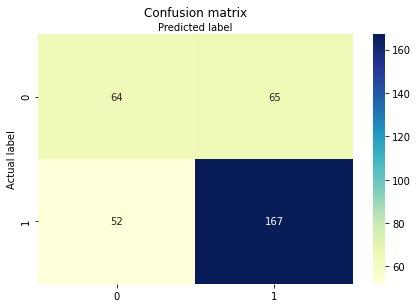

In [3641]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

if params["objective"] == "binary:hinge":
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
        # create heatmap
    sns.heatmap(pd.DataFrame(confusion_matrix(y_test, ypred)), annot=True, 
                cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [3622]:
fallout, sensitivity, thresholds = roc_curve(y_test, ypred)

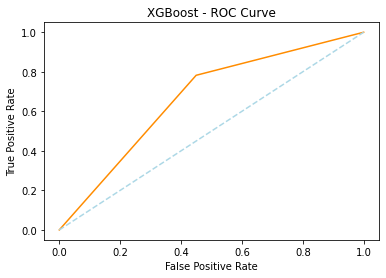

--------------------------------------------------
---------------- AUC Score: 0.666 ----------------
--------------------------------------------------


In [3623]:
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color = "lightblue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.show()

from sklearn.metrics import roc_auc_score
print(50 * "-")
print(str("-" * 16) + " AUC Score: " + str(round(roc_auc_score(y_test.values , ypred),3)) + " " + str("-" * 16))
print(50 * "-")

In [3450]:
data_for_test_xgboost['marketV_to_bookV'] = data_for_test_xgboost['marketV_to_bookV'].astype(float)

In [3451]:
d_validation = xgb.DMatrix(data_for_test_xgboost, label=y_test.values, feature_names=X_test.columns)

In [3452]:
def predict(xs):
    return model.predict(xgb.DMatrix(xs))

In [3453]:
predict(data_for_test_xgboost)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [3454]:
predicts = list(predict(data_for_test_xgboost))

In [3455]:
indexes = [i for i in range(len(predicts)) if predicts[i]  == 0]
indexes

[13, 15, 17, 19, 32, 34, 40, 41, 44, 47, 52, 55, 57, 61, 67, 68, 69, 72]